In [1]:
!rm -rf /kaggle/working/
!git clone https://github.com/svenspa/FML.git

rm: cannot remove '/kaggle/working/': Device or resource busy
Cloning into 'FML'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (474/474), done.
remote: Compressing objects: 100% (330/330), done.
remote: Total 474 (delta 221), reused 368 (delta 133), pack-reused 0
Receiving objects: 100% (474/474), 1.22 MiB | 3.42 MiB/s, done.
Resolving deltas: 100% (221/221), done.


In [2]:
import os
origin_path = "/kaggle/working"
fml_path = "/kaggle/working/FML"

In [3]:
!pip install arch
!pip install yfinance
!pip install fastparquet

     |████████████████████████████████| 902 kB 545 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=7fa8a2d30405c08876d54b009cc001f8ae4482a6be285d000b8ab3188148b717
  Stored in directory: /root/.cache/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking
     |████████████████████████████████| 1.2 MB 533 kB/s            
     |████████████████████████████████| 59 kB 4.9 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 1.6 MB 45.5 MB/s            
  Created wheel for thrift: filename=thrift-0.15.0-cp37-cp37m-linux_x86_64.whl size=413785 sha256=ef978895f84a9e2c979ffa50f8562fb14606e2557632a37977987e6bc65f17f9
  Stored in directory: /root/.cache/pip/wheels/ba/1f/8e/e6fd36837eecf3d1f2b23f1729477e8e06558d8d60b7093f51
Successfully built thrift


In [4]:
os.chdir(fml_path)

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import yfinance as yf

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

from data import DataGJR, DataRes
from market_dynamics import bs_call_price
from models import ControlNet, EnsembleNet
from train import train_val
from risk_measures import median_loss
from utils import call_payoff, stochastic_integral


In [6]:
GJR_FOLDER = "../input/gjr-vol/v2_2/v2/"
RES_FOLDER = "../input/gjr-vol/ressim/resssim/"

In [7]:
os.chdir(origin_path)

## Data

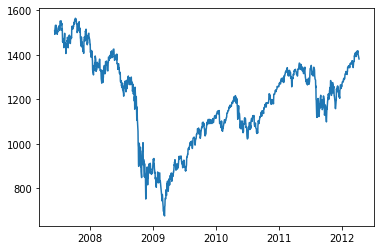

In [8]:
ticker = yf.Ticker('^GSPC')
hist = ticker.history(start='2007-06-11', end='2012-04-10').Close
plt.plot(hist);

In [9]:
# From fitting the GARCH model using R get following parameters

SIGMA = 0.1221684
MU = 0.056105

SQRT_252 = 252 ** 0.5

In [10]:
h_params = {"N_SIM": 4000,
            "RF": 0,
            "N_DIMS": 2,
            "FC_DIM": 20,
            "LR": 0.005,
            "GAMMA": 0.96,
            "EPOCHS": 10,
            "BATCH_SIZE": 256,}

In [11]:
initial_value = hist.iloc[0]
strike = initial_value
n_steps = 30
price = bs_call_price(n_steps, initial_value, SIGMA, h_params["RF"], strike)
initial_value, strike, SIGMA, price

(1509.1199951171875, 1509.1199951171875, 0.1221684, 21.0855397479188)

In [12]:
dt = DataGJR(GJR_FOLDER, price, call_payoff, {"strike": strike}, splits=h_params["N_SIM"], S0=initial_value, sigma_0=SIGMA, mu_const=MU, take_log=True, vol_feature=False)

## Training

In [13]:
%%time

# Training three models on different training paths

n_models = 3
models, optimizers, schedulers = [], [], []
n = 1000
val_n = 20
criterion = torch.nn.MSELoss()

for _ in range(n_models):
    model = ControlNet(n_steps, 1, [20, 20], 1, learn_price=False, learn_vol=False)
    models.append(model)
    optimizer = Adam(model.parameters(), lr=h_params["LR"])
    optimizers.append(optimizer)
    schedulers.append(ExponentialLR(optimizer, gamma=h_params["GAMMA"]))

idx_list = np.array_split(np.arange(n) + 1, 3)
val_idx_list = [np.arange(start=idx[-1]+1, stop=idx[-1]+1+val_n) for idx in idx_list]

# Training each model

res_list = []
for model, optimizer, scheduler, indices, val_indices in zip(models, optimizers, schedulers, idx_list, val_idx_list):
    results = train_val(dt, model, criterion, optimizer, h_params["EPOCHS"], indices, val_indices, scheduler, metric=median_loss, val_every=5)
    res_list.append(results)

ens = EnsembleNet(models)

Epoch 0: 100%|██████████| 334/334 [00:25<00:00, 13.27batch/s, loss=53.4, metric=19.7]


validation loss: 6469.90576171875


Epoch 5: 100%|██████████| 334/334 [00:21<00:00, 15.32batch/s, loss=43.5, metric=17.8]


validation loss: 51.587416076660155


Epoch 0: 100%|██████████| 333/333 [00:25<00:00, 13.13batch/s, loss=52.7, metric=19]


validation loss: 546.6262420654297


Epoch 5: 100%|██████████| 333/333 [00:21<00:00, 15.16batch/s, loss=44.6, metric=13.1]


validation loss: 49.617409324646


Epoch 0: 100%|██████████| 333/333 [00:25<00:00, 13.04batch/s, loss=36.7, metric=16.6]


validation loss: 5694.839184570313


Epoch 5: 100%|██████████| 333/333 [00:22<00:00, 14.99batch/s, loss=33.6, metric=15.1]


validation loss: 1043.6737579345704


Epoch 9: 100%|██████████| 333/333 [00:22<00:00, 14.66batch/s, loss=32.6, metric=15.5]

CPU times: user 15min 46s, sys: 41.5 s, total: 16min 28s
Wall time: 11min 17s


## Performance on GJR validation paths & Delta Hedging Benchmark

In [14]:
# Cython code based on: https://github.com/JackJacquier/python-for-finance/blob/master/Session-7-Cython/Intro_to_Cython.ipynb

In [15]:
%load_ext Cython

In [16]:
%%cython --compile-args=-O3
cimport cython
from libc.math cimport  sqrt,log,exp,erf
cdef double ONE_OVER_SQRT_TWO=0.7071067811865476
import numpy as np
cimport numpy as cnp

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef double gaussian_cdf(double x) nogil:
    return 0.5*(1+erf(x*ONE_OVER_SQRT_TWO))

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef cnp.ndarray[cnp.double_t, ndim=1] cython_bs_delta(cnp.ndarray[cnp.double_t, ndim=1] sigma, cnp.ndarray[cnp.double_t, ndim=1] S0,double K, cnp.ndarray[cnp.double_t, ndim=1] T):
    cdef int size=len(S0)
    cdef double k, d1, sigmaT
    cdef cnp.ndarray[cnp.double_t, ndim=1] result=np.zeros(size)
        
    with nogil:
        for i in range(size):
            sigmaT = sigma[i] * sqrt(T[i])
            k = log(S0[i] / K)
            d1 = k / sigmaT + 0.5*sigmaT
            result[i] = gaussian_cdf(d1)
        
    return result

In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /root/.cache/ipython/cython/_cython_magic_679ba82c68a37a119a6ddd02f3956e57.c:644:
/opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [17]:
# make index to pass decreasing time to maturity to the bs_delta function
idx = np.arange(n_steps) + 1
idx = idx[::-1]

In [18]:
def cython_d_hedge(x, vol):
    return cython_bs_delta(vol.numpy().astype(np.float64), torch.exp(x).numpy().astype(np.float64), strike, idx.astype(np.float64) *  ( 1 / 365))

def hedge_diff(x, x_inc, payoff, price, vol, model=ens, normalized=True, x1=None):

    # calculate delta hedge; assuming x is log price!
    if normalized:
        path = initial_value * x
    else:
        path = x
    
    d_hedge_list = [cython_d_hedge(a.squeeze(), b.squeeze()) for a, b in zip(path, vol)]
    si_delta = stochastic_integral(x_inc, torch.Tensor(d_hedge_list))
    diff_delta = (price.squeeze() + si_delta).float() - payoff.float()

    # calculating model hedge
    if dt.vol_feature:
        output = model(x, x1)
    else:
        output = model(x)

    if model.learn_price:
        output, price = output

    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()

    return diff, diff_delta

In [19]:
diffs, diffs_delta = [], []

for i in np.arange(start=3500, stop=3700):
    
    if dt.vol_feature:
        x, x1, x_inc, payoff, price = dt[i]
    else:
        x, x_inc, payoff, price = dt[i]
        x1 = None
        
    vol = dt.get_vol(i)
    diff, diff_delta = hedge_diff(x, x_inc, payoff, price, vol, x1=x1)
    diffs.append(diff)
    diffs_delta.append(diff_delta)
    
d = torch.cat(diffs)
d_delta = torch.cat(diffs_delta)

In [20]:
print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

print('Delta Hedge:')
print(f"RMSE {(d_delta ** 2).mean() ** 0.5}")
print(f"Using median {(d_delta ** 2).median() ** 0.5}")
print(f"Using mode {(d_delta ** 2).mode()[0] ** 0.5}")

Model:
RMSE 6.7304182052612305
Using median 3.3988037109375
Using mode 0.4808349609375
Delta Hedge:
RMSE 15.667876243591309
Using median 9.739227294921875
Using mode 21.085538864135742


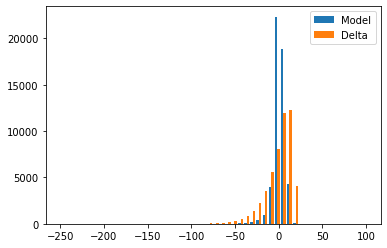

In [21]:
plt.hist([d.detach().numpy(), d_delta.detach().numpy()], range=(-250, 100), bins=50, label=['Model', 'Delta'])
plt.legend();

In [22]:
pd.Series(d_delta.detach()).describe()

count    51200.000000
mean        -0.094304
std         15.667855
min       -204.078278
25%         -7.247254
50%          3.881438
75%         10.595092
max         21.085539
dtype: float64

In [23]:
d_series = pd.Series(d.detach())
d_series.describe()

count    51200.000000
mean         1.201535
std          6.622326
min       -140.333481
25%         -1.447788
50%          1.486037
75%          4.880297
max         18.932364
dtype: float64

## Performance on real paths

In [24]:
# Creating the validation paths
n_steps = 30# Creating the validation paths

n_steps = 30
step = 5  # number of days by which to shift the window
sigma_est_period = 30
valid_paths, valid_prices, valid_strikes, sigma_estimates = [], [], [], []

for i in np.arange(start=sigma_est_period, stop=len(hist) - n_steps, step=step):
    
    valid_path = hist[i:i+n_steps+1]
    simga_est_path = hist[i-sigma_est_period:i]
    sigma_est = simga_est_path.diff().dropna().std() / 100
    sigma_estimates.append(sigma_est)

    S0 = valid_path[0]
    valid_price = bs_call_price(n_steps, S0, sigma=sigma_est, rf=0, strike=S0)      

    valid_paths.append(valid_path)
    valid_strikes.append(S0)
    valid_prices.append(valid_price)

valid_paths = np.array(valid_paths)
valid_paths = valid_paths.reshape(valid_paths.shape[0], valid_paths.shape[1], 1)
valid_paths = torch.from_numpy(valid_paths).float()

valid_prices = torch.Tensor(valid_prices)
valid_strikes = torch.Tensor(valid_strikes)

In [25]:
if dt.take_log:
    paths = valid_paths.squeeze().T /  valid_paths[:, 0].squeeze()
    paths = paths.T
    paths = torch.unsqueeze(paths, dim=2)
    paths = torch.log(paths[:, :-1])
    x_inc = valid_paths.squeeze().diff()

    payoff = call_payoff(valid_paths.squeeze(), strike=valid_strikes)

In [26]:
output = ens(paths)
si = stochastic_integral(x_inc, output)
diff = (valid_prices.squeeze() + si).float() - payoff.float()
d = diff

In [27]:
print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")

Model:
RMSE 24.036222457885742
Using median 11.96778392791748


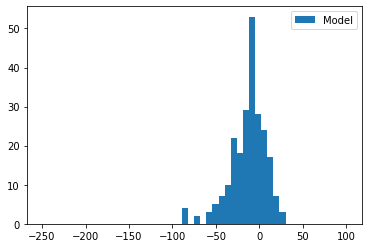

In [28]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

In [29]:
d_series = pd.Series(d.detach())
d_series.describe()

count    232.000000
mean     -12.832304
std       20.368107
min      -86.087708
25%      -23.164063
50%       -9.151287
75%       -0.131922
max       28.831291
dtype: float64